In [1]:
#Liangco, Ma. Karizza F.
#COE005 - GAN Exercise

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from glob import glob
import cv2
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

C:\Users\kariz\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Importing the Gathered Dataset
train_apple_path = glob("apple2orange/trainA"+"/*")
train_orange_path = glob("apple2orange/trainB"+"/*")

test_apple_path = glob("apple2orange/testA"+"/*")
test_orange_path = glob("apple2orange/testB"+"/*")

In [3]:
#Preparing the Dataset
train_apple = []
train_orange = []

test_apple = []
test_orange = []

for path in train_apple_path:
    img = cv2.imread(path)
    img = cv2.resize(img,(256,256))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    train_apple.append(img)
    
for path in train_orange_path:
    img = cv2.imread(path)
    img = cv2.resize(img,(256,256))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    train_orange.append(img)

for path in test_apple_path:
    img = cv2.imread(path)
    img = cv2.resize(img,(256,256))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    test_apple.append(img)
    
for path in test_orange_path:
    img = cv2.imread(path)
    img = cv2.resize(img,(256,256))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    test_orange.append(img)

train_apple = np.array(train_apple).astype(np.float32) / 127.5 - 1
test_apple = np.array(test_apple).astype(np.float32) / 127.5 -1 

train_orange = np.array(train_orange).astype(np.float32) / 127.5 - 1
test_orange = np.array(test_orange).astype(np.float32) / 127.5 - 1

apple_ds = tf.data.Dataset.from_tensor_slices(train_apple).batch(1)
orange_ds = tf.data.Dataset.from_tensor_slices(train_orange).batch(1)

In [4]:
#Defining for Downsample
OUT_CHANNELS = 3
# Red Green and Blue

def downsample(filters,filter_size,apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.,stddev=0.02)
    
    model = keras.Sequential()
    model.add(layers.Conv2D(filters,filter_size,strides=2,padding="same",kernel_initializer=initializer,use_bias=False))
    
    if apply_instancenorm:
        model.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    model.add(layers.LeakyReLU())
    
    return model

In [5]:
#Defining for Upsample
def upsample(filters,filter_size,apply_dropout=False):
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0,stddev=0.02)
    
    model = keras.Sequential()
    model.add(layers.Conv2DTranspose(filters,
                                     filter_size,
                                     strides=2,
                                     padding="same",
                                     kernel_initializer=initializer,
                                     use_bias=False
                                    ))
    
    
    model.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    if apply_dropout:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.ReLU())
    return model

In [6]:
#Defining the Generator
def Generator():
    inputs = layers.Input([256,256,3])
    
    downstack = [
        downsample(64,4,apply_instancenorm=False), # 128x128
        downsample(128,4), # 64x64
        downsample(256,4), # 32x32
        downsample(512,4), # 16x16
        downsample(512,4), # 8x8
        downsample(512,4), # 4x4
        downsample(512,4), # 2x2
        downsample(512,4) # 1x1
    ]
    
    upstack = [
        upsample(512,4,apply_dropout=True), # 2x2
        upsample(512,4,apply_dropout=True), # 4x4
        upsample(512,4,apply_dropout=True), # 8x8
        upsample(512,4), # 16x16
        upsample(256,4), # 32x32
        upsample(128,4), # 64x64
        upsample(64,4) # 128x128
        
        # We'll add last layer to gain a 256x256 image
    ]
    
    initializer = tf.random_normal_initializer(0.,0.02)
    
    last = layers.Conv2DTranspose(OUT_CHANNELS,
                                  4,
                                  strides=2,
                                  padding="same",
                                  activation="tanh",
                                  kernel_initializer=initializer)
    
    
    # Now in order to solve vanishing gradient problem, we'll connect layers using skip connections
    
    x = inputs
    
    skips = []
    for down in downstack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    for up,skip in zip(upstack,skips):
        x = up(x)
        x = layers.Concatenate()([x,skip])
        
    x = last(x)
    
    return tf.keras.Model(inputs=inputs,outputs=x)

In [7]:
#Defining the Discriminator
def Discriminator():
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.,stddev=0.02)
    
    inputs = layers.Input(shape=(256,256,3),name="input_layer")
    
    x = inputs
    
    down1 = downsample(64,4,False)(x)
    down2 = downsample(128,4)(down1)
    down3 = downsample(256,4)(down2)
    
    zero_pad = layers.ZeroPadding2D()(down3)
    
    conv = layers.Conv2D(512,4,strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad)
    
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    
    leaky_relu = layers.LeakyReLU()(norm1)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    
    last = layers.Conv2D(1,4,strides=1,kernel_initializer=initializer)(zero_pad2)
    
    return tf.keras.Model(inputs=inputs,outputs=last)


In [8]:
orange_generator = Generator()
apple_generator = Generator()

orange_discriminator = Discriminator()
apple_discriminator = Discriminator()

In [29]:
#Building the Model
class CycleGAN(keras.Model):
    
    def __init__(self,
                 orange_generator,
                 apple_generator,
                 orange_discriminator,
                 apple_discriminator,
                 lambda_cycle=10
                ):
        
        super(CycleGAN,self).__init__()
        self.o_gen = orange_generator
        self.a_gen = apple_generator
        self.o_disc = orange_discriminator
        self.a_disc = apple_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self,
            o_gen_optimizer,
            a_gen_optimizer,
            o_disc_optimizer,
            a_disc_optimizer,
            gen_loss_fn,
            disc_loss_fn,
            cycle_loss_fn,
            identity_loss_fn
            ):
        
        super(CycleGAN,self).compile()
        self.o_gen_optimizer = o_gen_optimizer
        self.a_gen_optimizer = a_gen_optimizer
        self.o_disc_optimizer = o_disc_optimizer
        self.a_disc_optimizer = a_disc_optimizer
        
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
        """
        We've created attributes
        """
        
    def train_step(self,batch_data):
        real_orange,real_apple = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # apple to orange to apple
            fake_orange = self.o_gen(real_apple,training=True)
            cycled_apple = self.a_gen(fake_orange,training=True)
            
            # orange to apple to orange
            fake_apple = self.a_gen(real_orange,training=True)
            cycled_orange = self.o_gen(fake_apple,training=True)
            
            # orange to orange, apple to apple
            same_orange = self.o_gen(real_orange,training=True)
            same_apple = self.a_gen(real_apple,training=True)
            
            # discriminator detects whether orange are real or not
            disc_real_orange = self.o_disc(real_orange,training=True)
            disc_fake_orange = self.o_disc(fake_orange,training=True)
            
            # discriminator detects whether apples are real or not
            disc_real_apple = self.a_disc(real_apple,training=True)
            disc_fake_apple = self.a_disc(fake_apple,training=True)
            
            # computing generator loss
            orange_gen_loss = self.gen_loss_fn(disc_fake_orange)
            apple_gen_loss = self.gen_loss_fn(disc_fake_apple)
            
             # computing cycle loss
            total_cycle_loss = self.cycle_loss_fn(real_orange,
                                                  cycled_orange,
                                                  self.lambda_cycle
                                                 ) + self.cycle_loss_fn(real_apple,
                                                                        cycled_apple,
                                                                        self.lambda_cycle
                                                                       )
            # computing total generator loss
            total_orange_gen_loss = orange_gen_loss + total_cycle_loss + self.identity_loss_fn(real_orange,
                                                                                             same_orange,
                                                                                             self.lambda_cycle
                                                                                            )
            
            total_apple_gen_loss = apple_gen_loss + total_cycle_loss + self.identity_loss_fn(real_apple,
                                                                                             same_apple,
                                                                                             self.lambda_cycle
                                                                                            )
            # computing discriminator loss
            orange_disc_loss = self.disc_loss_fn(disc_real_orange,disc_fake_orange)
            apple_disc_loss = self.disc_loss_fn(disc_real_apple,disc_fake_apple)
            
            """
            Now let's use these losses in order to compute gradients and update parameters
            """
        # computing gradients of generators
        orange_generator_gradients = tape.gradient(total_orange_gen_loss,
                                                  self.o_gen.trainable_variables
                                                 )
        
        apple_generator_gradients = tape.gradient(total_apple_gen_loss,
                                                  self.a_gen.trainable_variables
                                                 )
        
        # computing gradients of discriminator
        orange_discriminator_gradients = tape.gradient(orange_disc_loss,
                                                      self.o_disc.trainable_variables
                                                     )
        
        apple_discriminator_gradients = tape.gradient(apple_disc_loss,
                                                      self.a_disc.trainable_variables
                                                     )
        
        # applying gradients 
        
        self.o_gen_optimizer.apply_gradients(zip(orange_generator_gradients,
                                                 self.o_gen.trainable_variables
                                                ))
        
        self.a_gen_optimizer.apply_gradients(zip(apple_generator_gradients,
                                                 self.a_gen.trainable_variables
                                                ))
        
        
        self.o_disc_optimizer.apply_gradients(zip(orange_discriminator_gradients,
                                                  self.o_disc.trainable_variables
                                                 ))
        
        self.a_disc_optimizer.apply_gradients(zip(apple_discriminator_gradients,
                                                  self.a_disc.trainable_variables
                                                 ))
         # returning stats
        
        return {"orange_gen_loss":total_orange_gen_loss,
                "apple_gen_loss":total_apple_gen_loss,
                "orange_discriminator_loss":orange_disc_loss,
                "apple_discriminator_loss":apple_disc_loss
               }

In [30]:
#Defining the Loss and Optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)

def discriminator_loss(real,generated):
    
    real_loss = cross_entropy(tf.ones_like(real),real)
    fake_loss = cross_entropy(tf.zeros_like(generated),generated)
    
    total_loss = real_loss + fake_loss
    
    return total_loss * 0.5

In [31]:
def generator_loss(generated):
    # We've used ones-like becuase generator will try to fool discriminator
    return cross_entropy(tf.ones_like(generated),generated)

In [32]:
def calc_cycle_loss(real_image,cycled_image,LAMBDA):
    
    cycle_loss = tf.reduce_mean(tf.abs(real_image-cycled_image))
    
    return LAMBDA * cycle_loss

In [33]:
def identity_loss(real_image,same_image,LAMBDA):
    
    id_loss = tf.reduce_mean(tf.abs(real_image-same_image))
    
    return LAMBDA * id_loss

In [34]:
orange_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
apple_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

orange_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
apple_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [35]:
cycle_gan_model = CycleGAN(orange_generator,
                           apple_generator,
                           orange_discriminator,
                           apple_discriminator
                          )

In [36]:
#Compiling the Model
cycle_gan_model.compile(orange_generator_optimizer,
                        apple_generator_optimizer,
                        orange_discriminator_optimizer,
                        apple_discriminator_optimizer,
                        generator_loss,
                        discriminator_loss,
                        calc_cycle_loss,
                        identity_loss
                       )

In [37]:
#Training the Model
final_dataset = tf.data.Dataset.zip((orange_ds,apple_ds))

cycle_gan_model.fit(final_dataset,
                    epochs=10,
                   )

Epoch 1/10
995/995 [==============================] - 2387s 2s/step - orange_gen_loss: 4.8321 - apple_gen_loss: 4.8399 - orange_discriminator_loss: 0.6333 - apple_discriminator_loss: 0.6329
Epoch 2/10
995/995 [==============================] - 2391s 2s/step - orange_gen_loss: 3.6224 - apple_gen_loss: 3.6768 - orange_discriminator_loss: 0.6396 - apple_discriminator_loss: 0.6295
Epoch 3/10
995/995 [==============================] - 2298s 2s/step - orange_gen_loss: 3.3656 - apple_gen_loss: 3.4024 - orange_discriminator_loss: 0.6532 - apple_discriminator_loss: 0.6463
Epoch 4/10
995/995 [==============================] - 2409s 2s/step - orange_gen_loss: 3.1564 - apple_gen_loss: 3.2121 - orange_discriminator_loss: 0.6625 - apple_discriminator_loss: 0.6523
Epoch 5/10
995/995 [==============================] - 2373s 2s/step - orange_gen_loss: 3.0377 - apple_gen_loss: 3.0633 - orange_discriminator_loss: 0.6616 - apple_discriminator_loss: 0.6598
Epoch 6/10
995/995 [==============================

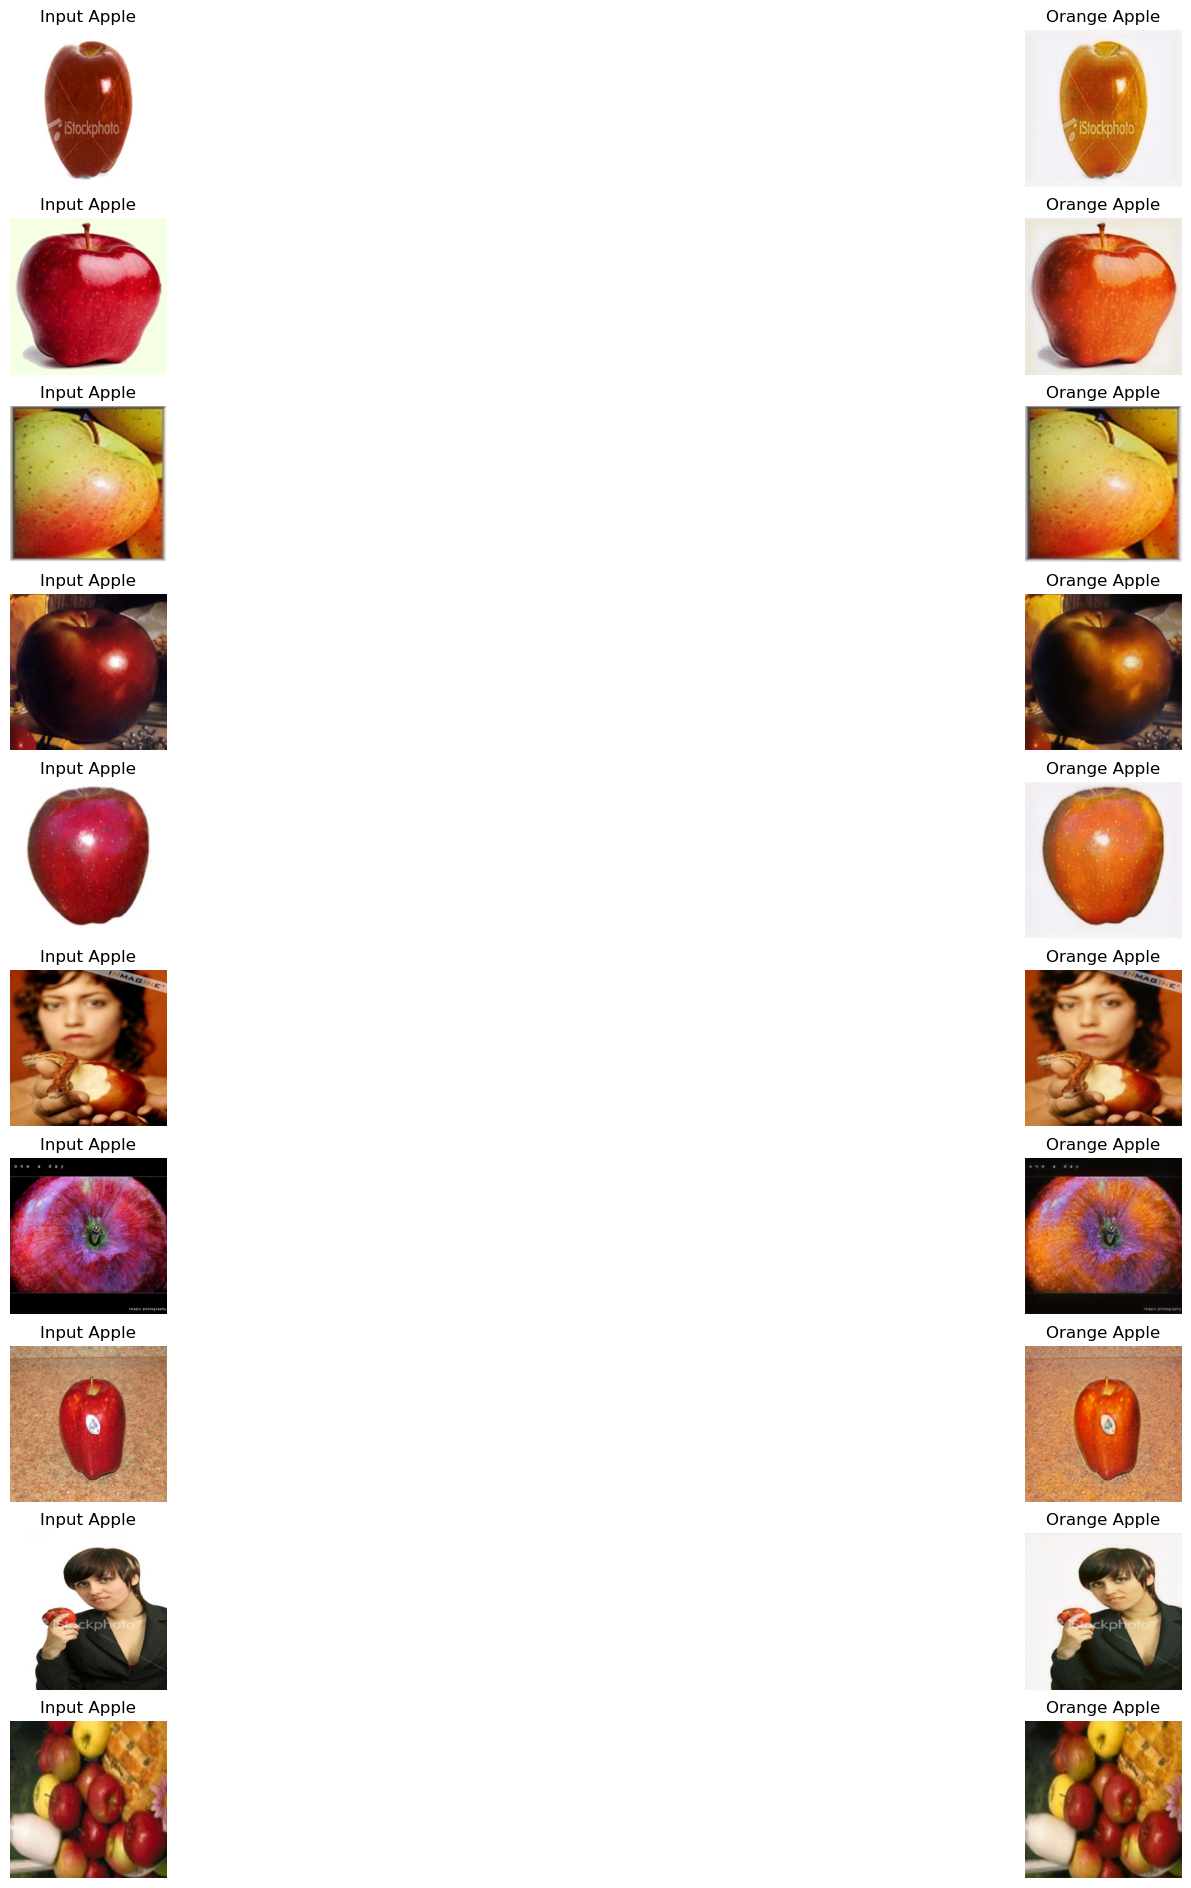

In [66]:
#Predicting and Evaluation
_, ax = plt.subplots(10, 2, figsize=(24,24))
for i, img in enumerate(apple_ds.take(10)):
    prediction = orange_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Apple")
    ax[i, 1].set_title("Orange Apple")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

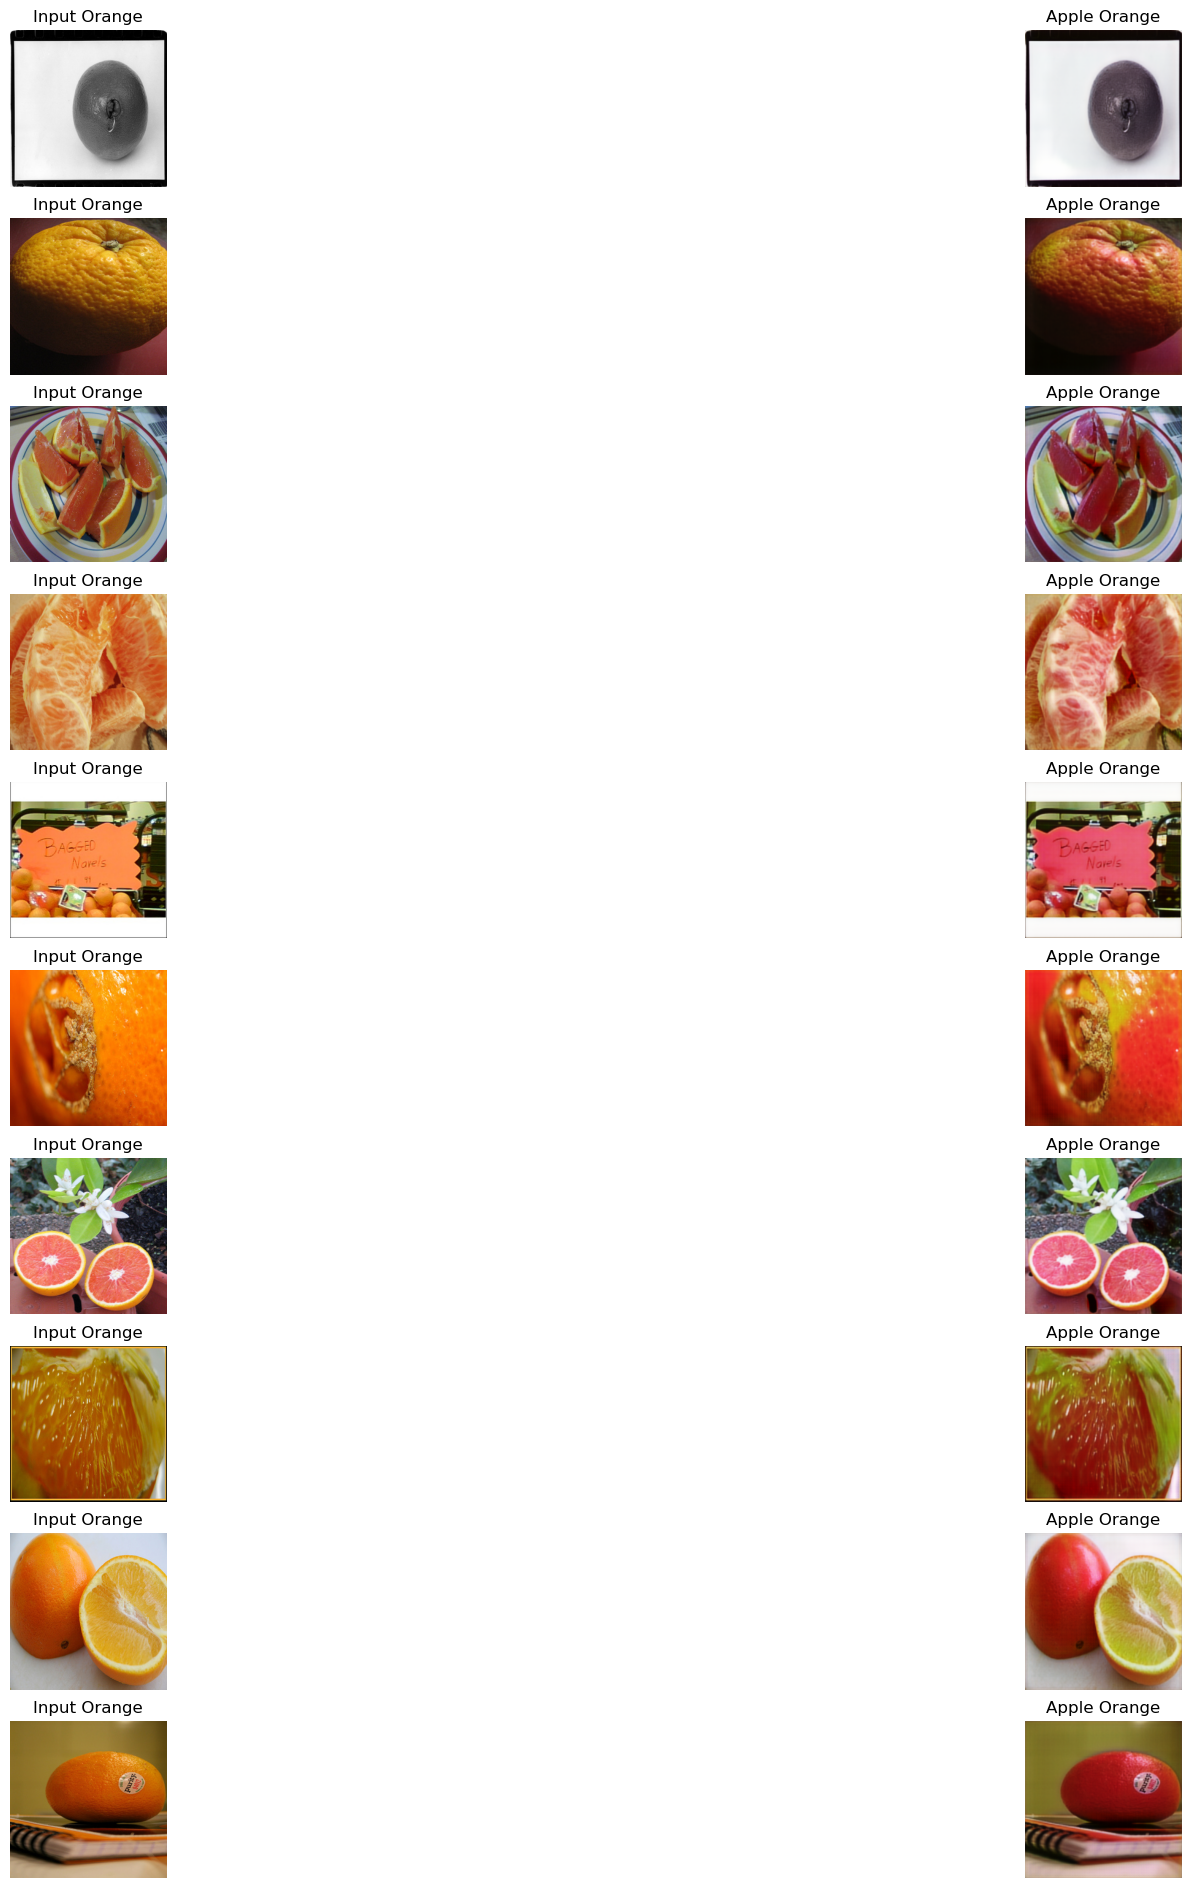

In [76]:
_, ax = plt.subplots(10, 2, figsize=(24,24))
for i, img in enumerate(orange_ds.take(10)):
    prediction = apple_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Orange")
    ax[i, 1].set_title("Apple Orange")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()